In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 1

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import ...

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from keras import backend as K

# Read Data

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction (2).csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [4]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

# Question 1

Real world datasets often contain a mix of numeric and categorical features – this dataset
is one such example. Modelling such a mix of feature types with neural networks requires
some modifications to the input layer. This tutorial from the Keras documentation guides
you through the process of using the Functional API to do so.


## Part (a)

Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets
by using entries from year 2020 and before as training data (with the
remaining data from year 2021 used as test data).
Why is this done instead of random train/test splits?

#### Insights:

*   The data has been divided to train and test data in the above code cell.
*   The split was based on year rather than random train/test splits. When dealing with time-related and dynamically changing settings, where the environment's features change over time, time-based splitting is the best way to give statistically robust model evaluation and best imitate real-life circumstances. 
*  We'd like to pick our train-test set sizes to reflect real-world scenarios in which we'd train a model over a period of time and then apply it to the next period. For instance, you could train the model on last month's data and then use it to forecast the coming week's data.



## Part (b)

Following this tutorial, design a 2-layer feedforward neural network
consisting of an input layer, a hidden layer (10 neurons, ReLU as activation
function), and a linear output layer. One-hot encoding should be applied
to categorical features and numeric features are standardised. After
encoding / standardisation, the input features should be concatenated. 

The input layer should use these features:<br>
Numeric features: dist_to_nearest_stn, dist_to_dhoby,
degree_centrality, eigenvector_centrality, remaining_lease_years,
floor_area_sqm<br>
Categorical features: month, flat_model_type, storey_range<br>
Your architecture should resemble the figure shown on the next page<br>

#### Insights:

* The encoding and feature scaling functions are created in previous code cells.
* I shall create layers and feature engineer them in the following code cell.
* I used layers.concatenate() to concatenate all the encoded features.

In [6]:
# Categorical features encoded as integers
from math import floor
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

all_inputs = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
]

all_features_model_1 = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]
)


In [7]:
# feedforward network with one hidden layer
x_1 = layers.Dense(10, activation="relu")(all_features_model_1)
output_1 = layers.Dense(1, activation="linear")(x_1)

## Part (c)

 On the training data, train the model for 100 epochs using mini-batch
gradient descent with batch size = 128, Use ‘adam’ optimiser with a
learning rate of 𝛼 = 0.05 and mean square error as cost function.
(Tip: Use smaller epochs while you’re still debugging. On Google
Colaboratory, 100 epochs take around 10 minutes even without GPU.)
 * I included R2(Coefficient of determination) as one of the metric as it will be required in the parts ahead.

In [8]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
model_1 = keras.Model(all_inputs, output_1)
model_1.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.05), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(),coeff_determination]
    )


* Model Architecture

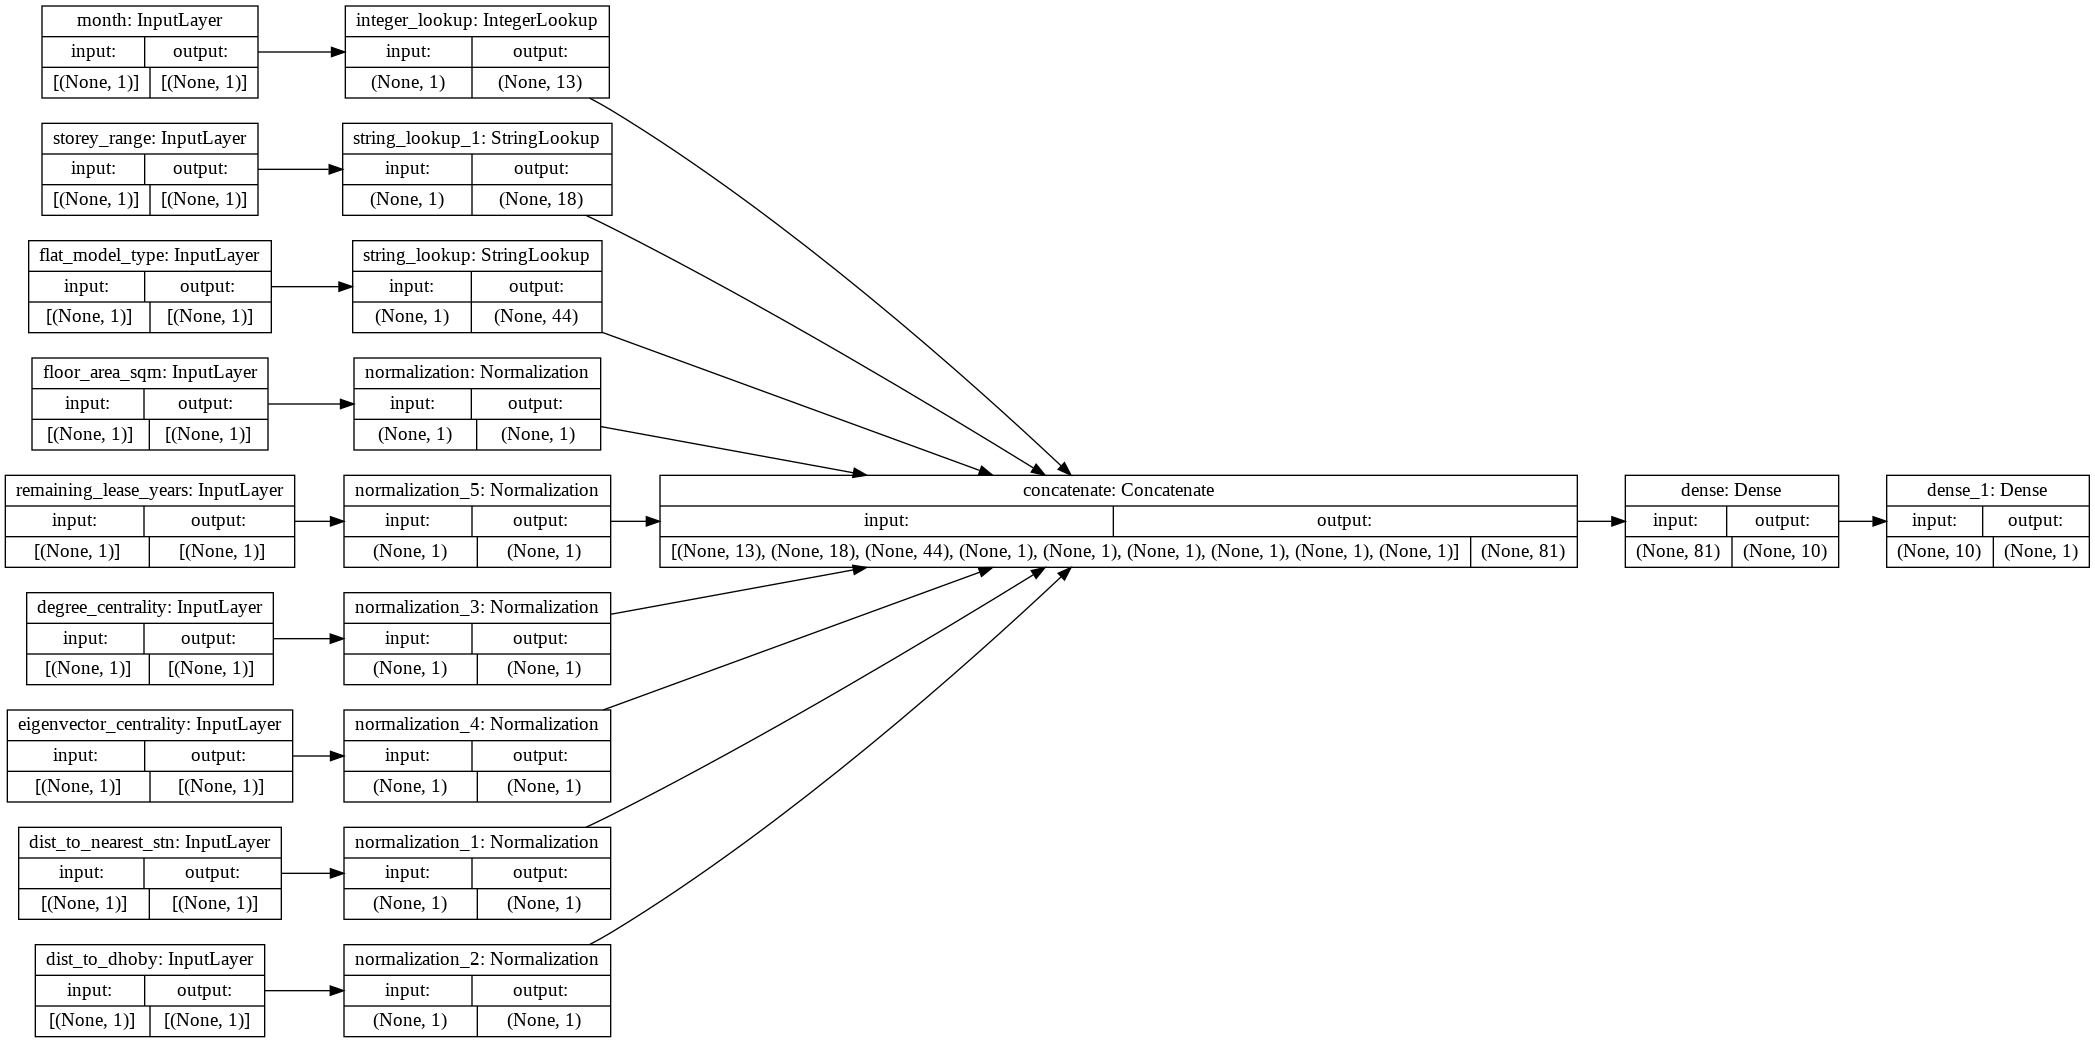

In [10]:
keras.utils.plot_model(model_1, show_shapes=True, rankdir="LR")

* Save the model with the best Validation RMSE

In [11]:
checkpoint_filepath_1 = 'weights.final.model_1.{epoch:02d}.tf'
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

In [12]:
history_1 = model_1.fit(train_ds, epochs=100, batch_size =128,callbacks=[model_checkpoint_callback_1], validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 4ms/step - loss: 191502123008.0000 - root_mean_squared_error: 437609.5625 - coeff_determination: -7.2422 - val_loss: 181434843136.0000 - val_root_mean_squared_error: 425951.6875 - val_coeff_determination: -6.1235
INFO:tensorflow:Assets written to: weights.final.model_1.01.tf/assets
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 76309372928.0000 - root_mean_squared_error: 276241.5000 - coeff_determination: -2.2749 - val_loss: 48552542208.0000 - val_root_mean_squared_error: 220346.4219 - val_coeff_determination: -0.8937
INFO:tensorflow:Assets written to: weights.final.model_1.02.tf/assets
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 13420406784.0000 - root_mean_squared_error: 115846.4766 - coeff_determination: 0.4294 - val_loss: 12350152704.0000 - val_root_mean_squared_error: 111131.2422 - val_coeff_determination: 0.5217
INFO:tensorflow:Assets written to: weights.final.model_1.03.tf/as

## Part (d)

* Plot the train and test root mean square errors (RMSE) against epochs
(Tip: skip the first few epochs, else the plot gets dominated by them). 

In [13]:
import matplotlib.pyplot as plt

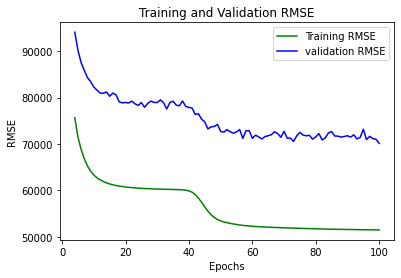

In [14]:
loss_train_1 = history_1.history['root_mean_squared_error']
loss_val_1 = history_1.history['val_root_mean_squared_error']
epochs = range(4,101)
plt.plot(epochs, loss_train_1[3:], 'g', label='Training RMSE')
plt.plot(epochs, loss_val_1[3:], 'b', label='validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Part (e)

State the epoch with the lowest test error. State the test R2 value at
that epoch. (Hint: Check the output returned by model.fit(). Use a
custom metric for computing R2
.)

In [15]:
min_index_1 = loss_val_1.index(min(loss_val_1))
best_epoch_1 = min_index_1 + 1
r_square_1 = history_1.history['val_coeff_determination'][min_index_1]
print('Best Epoch with the lowest test error: ', best_epoch_1)
print('Test R2 at the best epoch: ', r_square_1)

Best Epoch with the lowest test error:  100
Test R2 at the best epoch:  0.8082951307296753


## Part (f)

Using the model from that best epoch, plot the predicted values and
target values for a batch of 128 test samples. (Hint: Use a callback to
restore the best model weights. Find out how to retrieve a batch from
tf.BatchDataset. A scatter plot will suffice.)

* I used ModelCheckpoint to save the best model. I load the model from the saved model file.

In [16]:
best_model_path_1 = 'weights.final.model_1.' + str(best_epoch_1) + '.tf'
model_1.load_weights(best_model_path_1)

In [17]:
for data, labels in val_ds.take(1):  # only take first element of dataset
    test_data = data
    test_labels = labels.numpy()

In [18]:
y_pred_1 = model_1.predict(test_data)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Text(0, 0.5, 'Predictions')

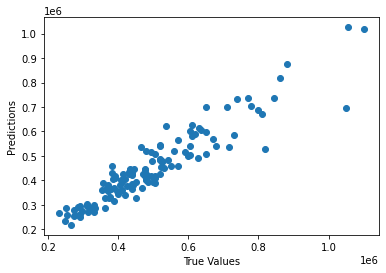

In [19]:
plt.scatter(list(test_labels), y_pred_1.tolist())
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Question 2
Instead of using one-hot encoding, an alternative approach entails the use of embeddings
to encode categorical variables. Such an approach utilises the ability of neural networks to
learn richer representations of the data – an edge it has over traditional ML models

## Part (a) & Part (b)

Add an Embedding layer with output_dim = floor(num_categories/2)
after the one-hot embeddings for categorical variables. (Hint: Use the
tf.keras.layers.Embedding() later. Read the documentation carefully to
ensure that you define the correct function parameters4
.) 

The Embedding layer produces a 2D output (3D, including batch),
which cannot be concatenated with the other features. Look through
the Keras layers API to determine which layer to add in, such that all
the features can be concatenated. Train the model using the same
configuration as Q1. (Tip: A full run takes ~15 mins, so reduce epochs
when debugging your code but remember to switch it back to 100.)

In [20]:
def func(feature,name,is_string):
  lookup = StringLookup(vocabulary=train_dataframe[name].unique()) if is_string else IntegerLookup(vocabulary=train_dataframe[name].unique())
  encoded_feature = lookup(feature)
  return encoded_feature


In [21]:
month_encod_fe = func(month,'month', False)
month_encoded_emb = keras.layers.Embedding(input_dim=len(list(df['month'].unique()))+1,output_dim=floor(len(list(df['month'].unique()))/2))(month_encod_fe)  
flatten_month_encoded_emb = keras.layers.Flatten()(month_encoded_emb)

# Categorical feature encoded as string
flat_model_type_encod_fe = func(flat_model_type,'flat_model_type', True)
flat_model_type_encoded_emb = keras.layers.Embedding(input_dim=len(list(df['flat_model_type'].unique()))+1,output_dim=floor(len(list(df['flat_model_type'].unique()))/2))(flat_model_type_encod_fe)  
flatten_flat_model_type_encoded_emb = keras.layers.Flatten()(flat_model_type_encoded_emb)

storey_range_encod_fe = func(storey_range,'storey_range', True)
storey_range_encoded_emb = keras.layers.Embedding(input_dim=len(list(df['storey_range'].unique()))+1,output_dim=floor(len(list(df['storey_range'].unique()))/2))(storey_range_encod_fe)
flatten_storey_range_encoded_emb = keras.layers.Flatten()(storey_range_encoded_emb)

all_inputs = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
]

all_features_model_2 = layers.concatenate(
    [
        flatten_month_encoded_emb,
        flatten_storey_range_encoded_emb,
        flatten_flat_model_type_encoded_emb,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]
)

In [22]:
x_2 = layers.Dense(10, activation="relu")(all_features_model_2)
output_2 = layers.Dense(1, activation="linear")(x_2)

In [23]:
model_2 = keras.Model(all_inputs, output_2)
model_2.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.05), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(),coeff_determination]
    )

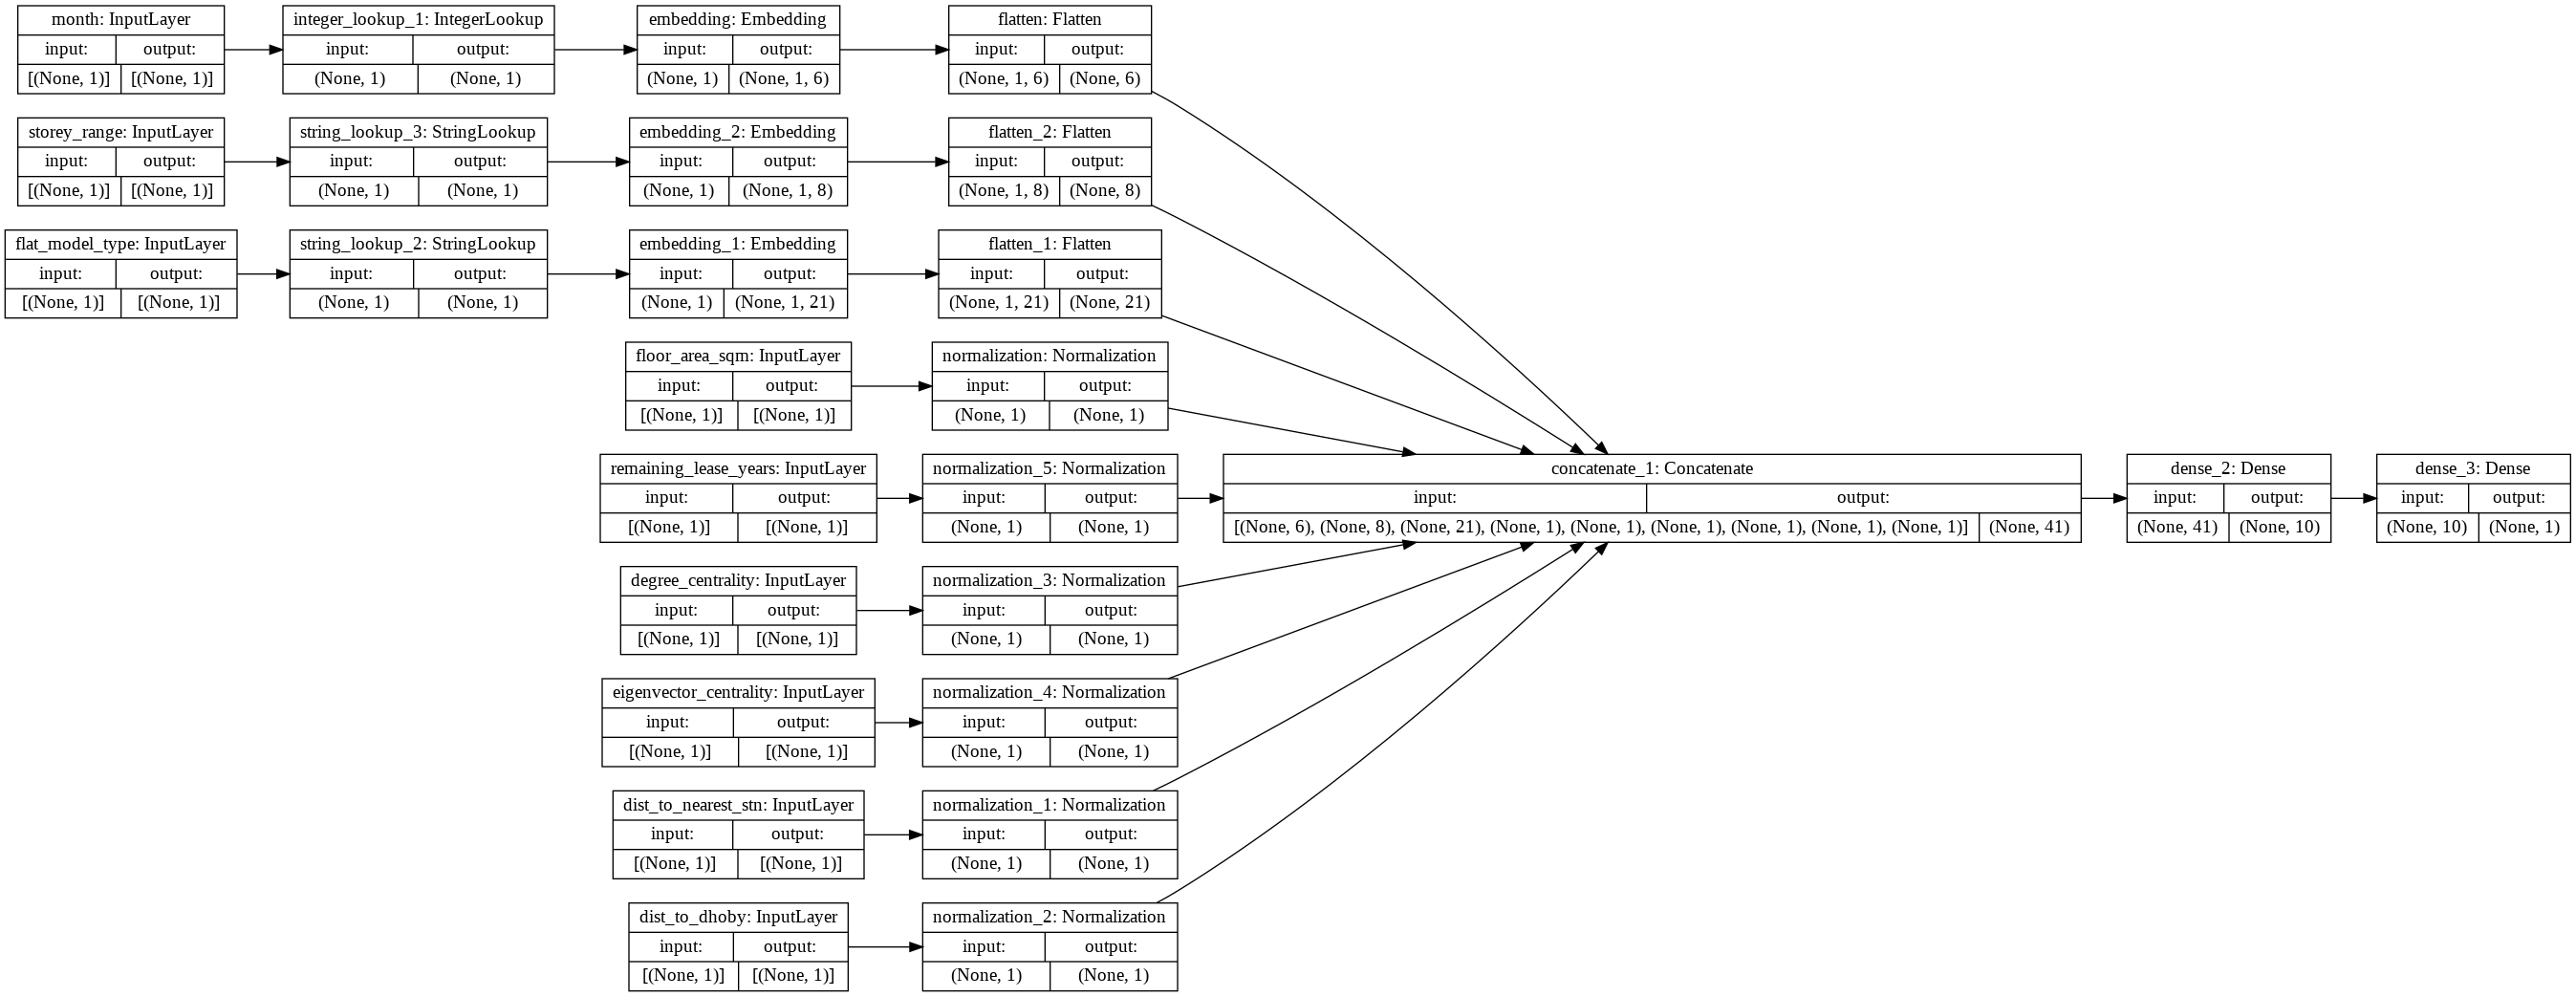

In [24]:
keras.utils.plot_model(model_2, show_shapes=True, rankdir="LR")

In [25]:
checkpoint_filepath_2 = 'weights.final.model_2.{epoch:02d}.tf'
model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

In [26]:
history_2 = model_2.fit(train_ds, epochs=100, batch_size=128,callbacks=[model_checkpoint_callback_2], validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 4ms/step - loss: 46701572096.0000 - root_mean_squared_error: 216105.4688 - coeff_determination: -1.0256 - val_loss: 12138070016.0000 - val_root_mean_squared_error: 110172.9062 - val_coeff_determination: 0.5310
INFO:tensorflow:Assets written to: weights.final.model_2.01.tf/assets
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 8071548416.0000 - root_mean_squared_error: 89841.7969 - coeff_determination: 0.6553 - val_loss: 10128268288.0000 - val_root_mean_squared_error: 100639.2969 - val_coeff_determination: 0.6065
INFO:tensorflow:Assets written to: weights.final.model_2.02.tf/assets
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 7004294656.0000 - root_mean_squared_error: 83691.6641 - coeff_determination: 0.7008 - val_loss: 8837585920.0000 - val_root_mean_squared_error: 94008.4375 - val_coeff_determination: 0.6579
INFO:tensorflow:Assets written to: weights.final.model_2.03.tf/assets
Epoch 

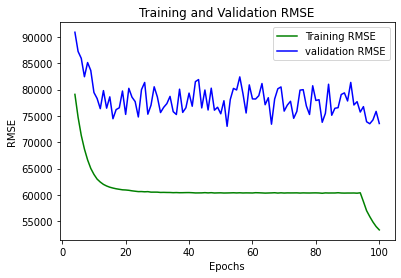

In [27]:
loss_train_2 = history_2.history['root_mean_squared_error']
loss_val_2 = history_2.history['val_root_mean_squared_error']
epochs = range(4,101)
plt.plot(epochs, loss_train_2[3:], 'g', label='Training RMSE')
plt.plot(epochs, loss_val_2[3:], 'b', label='validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Part (c)

Compare the current model performances in terms of both test RMSE
and test R2 with the model from Q1 (at their own best epochs) and
suggest a possible reason for the difference in performance. 

In [28]:
min_index_2 = loss_val_2.index(min(loss_val_2))
best_epoch_2 = min_index_2 + 1
r_square_2 = history_2.history['val_coeff_determination'][min_index_2]
print('Best Epoch with the lowest test error: ', best_epoch_2)
print('Test R2 at the best epoch: ', r_square_2)

Best Epoch with the lowest test error:  52
Test R2 at the best epoch:  0.792147696018219


In [29]:
best_model_path_2 = 'weights.final.model_2.' + str(best_epoch_2) + '.tf'
model_2.load_weights(best_model_path_2)

In [30]:
y_pred_2 = model_2.predict(test_data)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Text(0, 0.5, 'Predictions')

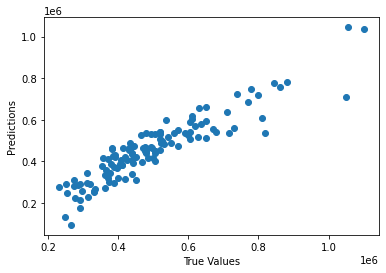

In [31]:
plt.scatter(list(test_labels), y_pred_2.tolist())
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rmse = mean_squared_error(list(test_labels), y_pred_1.tolist(), squared=False)
r2 = r2_score(list(test_labels), y_pred_1.tolist())
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 73722.53769267762
R2: 0.8069623056296036


In [33]:
rmse = mean_squared_error(list(test_labels), y_pred_2.tolist(), squared=False)
r2 = r2_score(list(test_labels), y_pred_2.tolist())
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 75673.33915878535
R2: 0.7966110447448083


#### Insights:

* Model from Q1 seems to perform better than the model from Q2(Both at their best epochs). Model from Q1 has approximately 2000 lowers RMSE as compared to model from Q2. 

* Both One-hot encoding and Embedding offer advantages, however One-hot encoding outperforms Embedding in this scenario. This is due to the fact that the number of category features is lower, using less memory (largest number of categories for a variable is 43). It's also because embedding takes a lot of data, and our dataset isn't big enough to take use of the advantages of embedding layers. As a result, using this dataset and model, one-hot encoding performs better.

# Question 3

Recursive feature elimination (RFE) is a feature selection method that removes
unnecessary features from the inputs. It can also shed some insights on how much each
feature contributes to the prediction task.

## Part (a)

Continue with the model architecture you have after Q2. Via a callback,
introduce early stopping (based on val_loss, with patience of 10 epochs) to
the model.

In [41]:
model_3 = keras.Model(all_inputs, output_2)
model_3.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.05), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(),coeff_determination]
    )

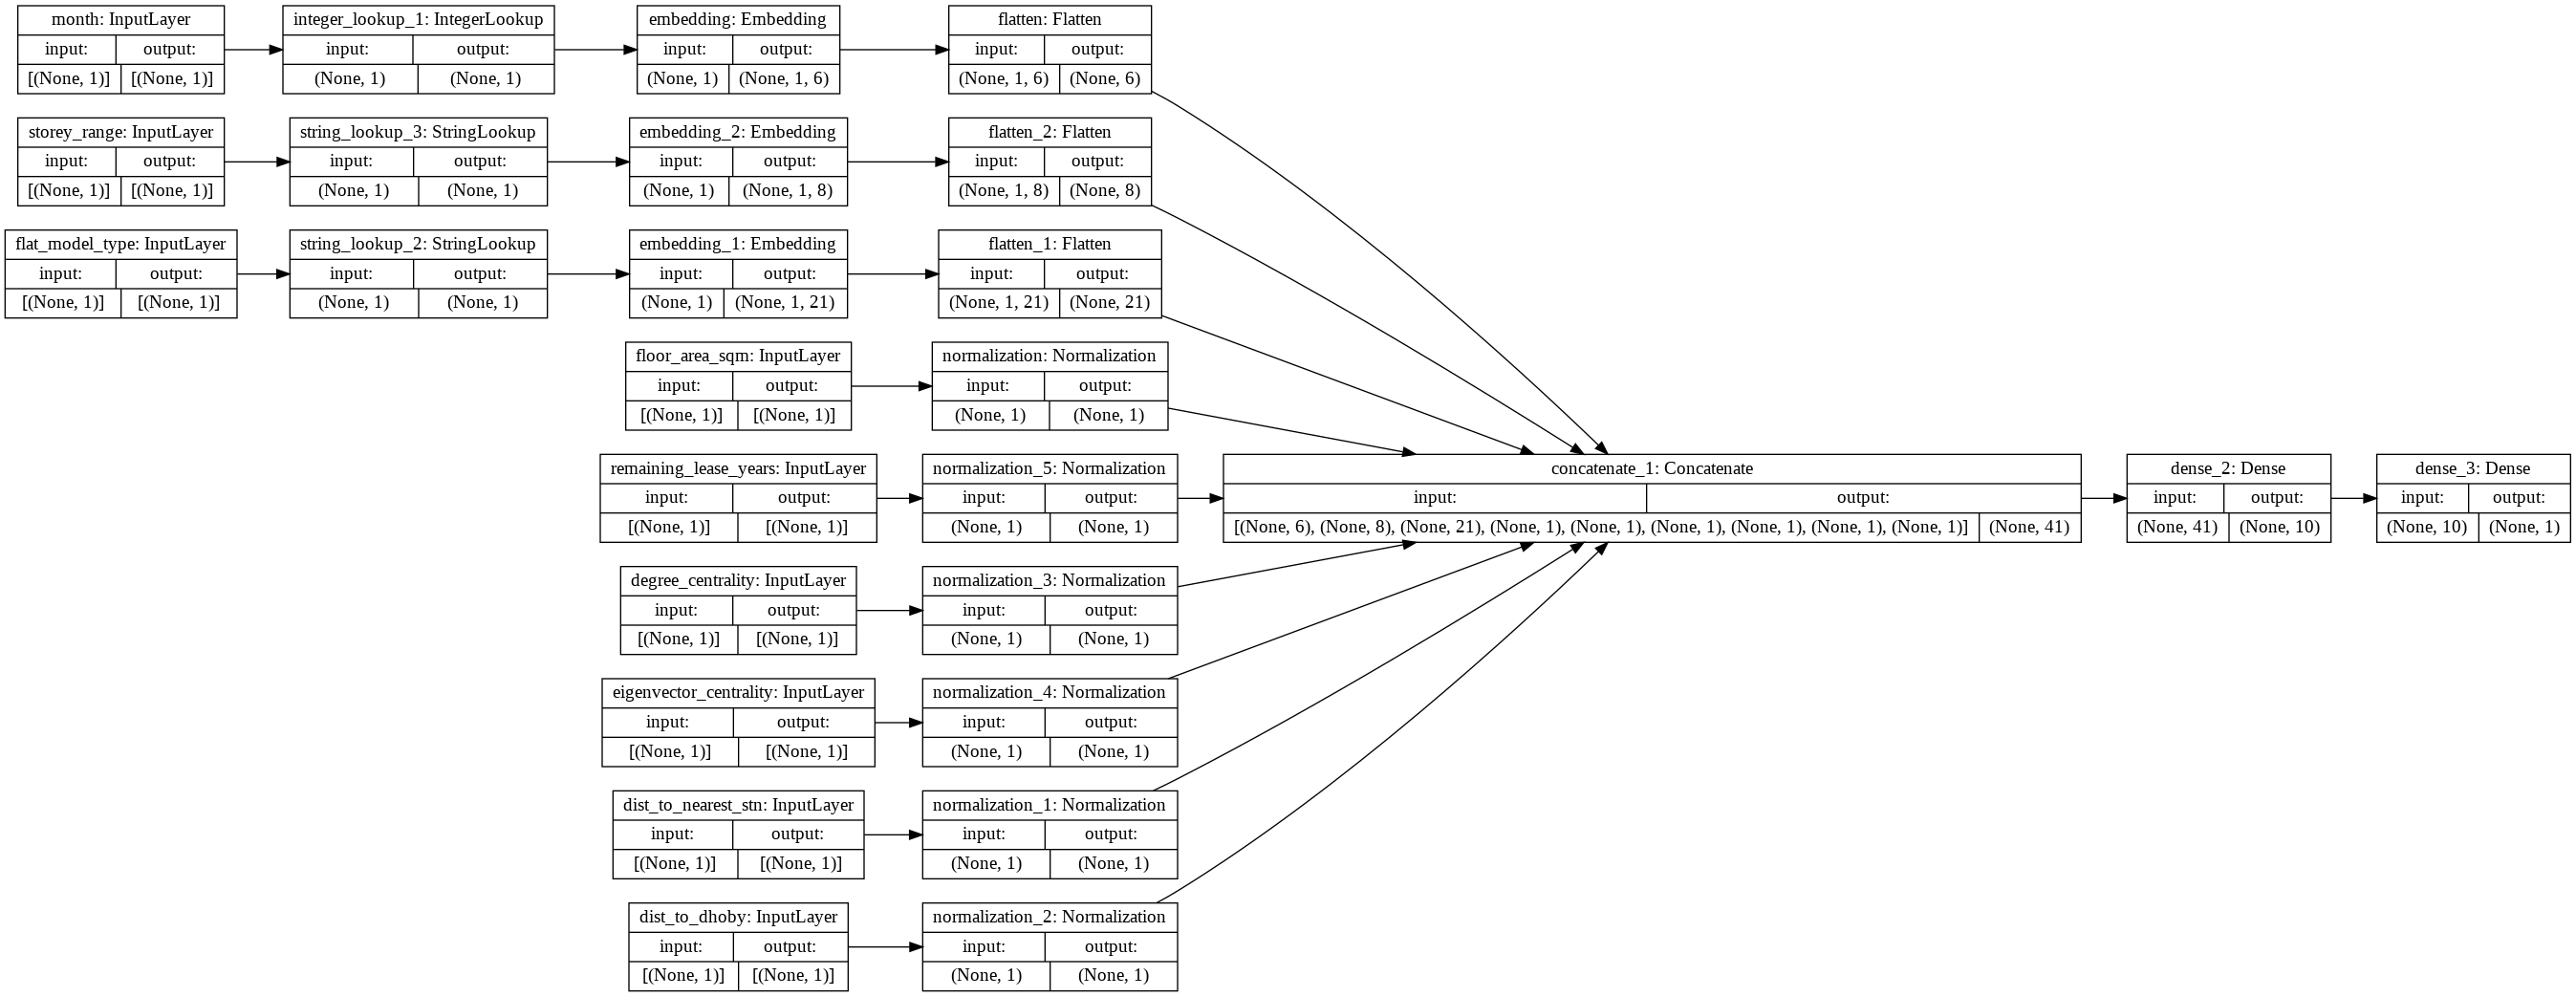

In [42]:
keras.utils.plot_model(model_3, show_shapes=True, rankdir="LR")

In [43]:
my_callbacks_3 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

In [44]:
history_3 = model_3.fit(train_ds, epochs=100, batch_size=128, callbacks=my_callbacks_3, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 4ms/step - loss: 30051971072.0000 - root_mean_squared_error: 173355.0469 - coeff_determination: -0.3247 - val_loss: 7749678592.0000 - val_root_mean_squared_error: 88032.2578 - val_coeff_determination: 0.7009
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 4109756672.0000 - root_mean_squared_error: 64107.3828 - coeff_determination: 0.8239 - val_loss: 6591257600.0000 - val_root_mean_squared_error: 81186.5625 - val_coeff_determination: 0.7441
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 3764978176.0000 - root_mean_squared_error: 61359.4180 - coeff_determination: 0.8384 - val_loss: 6317634560.0000 - val_root_mean_squared_error: 79483.5469 - val_coeff_determination: 0.7540
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 3678247680.0000 - root_mean_squared_error: 60648.5586 - coeff_determination: 0.8420 - val_loss: 5942913024.0000 - val_root_mean_squared_error: 77

## Part (b)

Start by removing one input feature whose removal leads to the minimum
drop (or maximum improvement) in performance
. Repeat the procedure
recursively on the reduced input set until the optimal number of input
features is reached
. Remember to remove features one at a time. Record
the RMSE of each experiment neatly in a table (i.e., without feature 1,
without feature 2, etc.). (Hint: Use a binary vector mask to keep track of the
features. When you remove a feature, you do not have to repeatedly remove
the initialisation of the input layers for each feature. Just choose which to
include when you concatenate the features. Make sure to clear the session
at every iteration of feature elimination. A full run take ~2hrs.) 

In [45]:
orig_features = [
        flatten_month_encoded_emb,
        flatten_storey_range_encoded_emb,
        flatten_flat_model_type_encoded_emb,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
  ]

In [46]:
def getModelFeatures(binary_vector_mask):
    features = orig_features.copy()
    inputs = all_inputs.copy()
    indices = [i for i, x in enumerate(binary_vector_mask) if x == 0]
    for index in sorted(indices, reverse=True):
        del features[index]
        del inputs[index]
    return features

In [60]:
no_features = 9

inputs_copy = [
   month,
   storey_range,
   flat_model_type,
   floor_area_sqm,
   remaining_lease_years,
   degree_centrality,
   eigenvector_centrality,
   dist_to_nearest_stn,
   dist_to_dhoby,
  ]

features_list_copy = [
        flatten_month_encoded_emb,
        flatten_storey_range_encoded_emb,
        flatten_flat_model_type_encoded_emb,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
  ]

lowest_test_RMSE = min(history_3.history['val_root_mean_squared_error'])
lowest_val_loss = min(history_3.history['val_loss'])
mini = lowest_test_RMSE
print("RMSE of previous model: " + str(mini))

binary_vector_mask = [1, 1, 1, 1, 1, 1, 1, 1, 1]

takeout_features = []
all_rmse = []
all_r2 = []
all_loss = []
mini_list = []

while (no_features > 1):
  current_mini = mini
  rmse = []
  r2 = []
  loss = []

  print("Iteration: " + str(10 - no_features))
  print("######################")

  for index, vector in enumerate(binary_vector_mask):

    if(vector == 1):

      tf.keras.backend.clear_session()

      binary_vector_mask[index] = 0
      features = getModelFeatures(binary_vector_mask)

      print("Binary Vector Mask: " + str(binary_vector_mask))

      binary_vector_mask[index] = 1 #Reset Mask

      print("Feature Removed at Index: " + str(index))

      all_features = layers.concatenate(features)

      x = layers.Dense(10, activation="relu")(all_features)
      output = layers.Dense(1, activation="linear")(x)

      model = keras.Model(inputs_copy, output)

      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), 
                    loss=tf.keras.losses.MeanSquaredError(), 
                    metrics=[tf.keras.metrics.RootMeanSquaredError(), coeff_determination])

      history = model.fit(train_ds,
                      epochs=100, 
                      batch_size=128,
                      verbose=0,
                      callbacks=[my_callbacks_3],
                      validation_data=val_ds)
      
      lowest_test_RMSE = min(history.history['val_root_mean_squared_error'])
      highest_test_R2 = max(history.history['val_coeff_determination'])
      lowest_val_loss = min(history.history['val_loss'])

      rmse.append(lowest_test_RMSE)
      r2.append(highest_test_R2)
      loss.append(lowest_val_loss)

      print("Validation Loss: " + str(lowest_val_loss))
      print("RMSE: " + str(lowest_test_RMSE))
      print("R2: " + str(highest_test_R2))
      print(" ")

      if lowest_test_RMSE < mini:
        mini = lowest_test_RMSE
        mini_index = index
        print(mini)
        print(mini_index)

  all_rmse.append(rmse)
  all_r2.append(r2)
  all_loss.append(loss)

  if current_mini <= mini:
    break
  
  print("Minimum RMSE:" + str(mini) + " for feature removed at index " + str(mini_index))
  print(" ")
  print("Comparing ######")

  binary_vector_mask[mini_index] = 0

  features = getModelFeatures(binary_vector_mask)
  print(features)

  r = inputs_copy[mini_index]
  takeout_features.append(r)
  features_list_copy.pop(mini_index)
  mini_list.append(mini)
  no_features -= 1

print(takeout_features)
print(all_rmse)
print(all_r2)
print(mini_list)

RMSE of previous model: 68110.1484375

Iteration: 1
######################

Binary Vector Mask: [0, 1, 1, 1, 1, 1, 1, 1, 1]
Feature Removed at Index: 0
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
Validation Loss: 3885820672.0
RMSE: 62336.3515625
R2: 0.8484179377555847
 
62336.3515625
0
Binary Vector Mask: [1, 0, 1, 1, 1, 1, 1, 1, 1]
Feature Removed at Index: 1
Validation Loss: 4701279744.0
RMSE: 68565.875
R2: 0.817419707775116
 
Binary Vector Mask: [1, 1, 0, 1, 1, 1, 1, 1, 1]
Feature Removed at Index: 2
Validation Loss: 4714441216.0
RMSE: 68661.7890625
R2: 0.8154597878456116
 
Binary Vector Mask: [1, 1, 1, 0, 1, 1, 1, 1, 1]
Feature Removed at Index: 3
Validation Loss: 4444558848.0
RMSE: 66667.5234375
R2: 0.8257359862327576
 
Binary Vector Mask: [1, 1, 1

In [57]:
dict_table = {
    'Without_Feature': ['month',
                        'storey_range',
                        'flat_model_type',
                        'floor_area_sqm',
                        'remaining_lease_years',
                        'degree_centrality',
                        'eigenvector_centrality',
                        'dist_to_nearest_stn',
                        'dist_to_dhoby',
                        'month-storey_range',
                        'month-flat_model_type',
                        'month-floor_area_sqm',
                        'month-remaining_lease_years',
                        'month-degree_centrality',
                        'month-eigenvector_centrality',
                        'month-dist_to_nearest_stn',
                        'month-dist_to_dhoby'],
         
     'RMSE':    ['62336.3515625',
                 '68565.875',
                 '68661.7890625',
                 '66667.5234375',
                 '70700.59375',
                 '65057.609375',
                 '65728.0859375',
                 '73626.75',
                 '83008.734375',
                 '68256.9609375',
                 '73290.9296875',
                 '66283.625',
                 '67269.4609375',
                 '523113.40625',
                 '66871.9453125',
                 '64873.34375',
                 '88546.46875'],
         
      'R2':    ['0.8484179377555847',
                 '0.817419707775116',
                 '0.8154597878456116',
                 '0.8257359862327576',
                 '0.8041307926177979',
                 '0.8343949913978577',
                 '0.8310897350311279',
                 '0.7886784076690674',
                 '0.7315988540649414',
                 '0.8181474208831787',
                 '0.7905385494232178',
                 '0.8281108736991882',
                 '0.8219557404518127',
                 '-9.704797744750977',
                 '0.8249243497848511',
                 '0.834252119064331',
                 '0.6935383677482605']
    
}

In [58]:
table_data = pd.DataFrame.from_dict(dict_table,orient='columns')
table_data

,Without_Feature,RMSE,R2
0,month,62336.3515625,0.8484179377555847
1,storey_range,68565.875,0.817419707775116
2,flat_model_type,68661.7890625,0.8154597878456116
3,floor_area_sqm,66667.5234375,0.8257359862327576
4,remaining_lease_years,70700.59375,0.8041307926177979
5,degree_centrality,65057.609375,0.8343949913978577
6,eigenvector_centrality,65728.0859375,0.8310897350311279
7,dist_to_nearest_stn,73626.75,0.7886784076690674
8,dist_to_dhoby,83008.734375,0.7315988540649414
9,month-storey_range,68256.9609375,0.8181474208831787


## Part (c)

 Compare the performances of the model with all 9 input features (from
Q2) and the best model arrived at by RFE, in terms of both RMSE and R2



* After comparing the validation RMSE and R2 of the model with all 9 input features (from Q2) and the best model arrived by RFE, In my case RFE model performs better. This can be as we are removing features that are not relevant for the model to predict and they adversely affect the performance.

  * RFE - val RMSE: 62336.3515625
  * RFE - val R2: 0.8484179377555847

  * Q2_Model - val RMSE: 73013.0391
  * Q2_Model - val R2: 0.7921

## Part (d)

In [61]:
table_data.sort_values(by=['RMSE'])

,Without_Feature,RMSE,R2
13,month-degree_centrality,523113.40625,-9.704797744750977
0,month,62336.3515625,0.8484179377555847
15,month-dist_to_nearest_stn,64873.34375,0.834252119064331
5,degree_centrality,65057.609375,0.8343949913978577
6,eigenvector_centrality,65728.0859375,0.8310897350311279
11,month-floor_area_sqm,66283.625,0.8281108736991882
3,floor_area_sqm,66667.5234375,0.8257359862327576
14,month-eigenvector_centrality,66871.9453125,0.8249243497848511
12,month-remaining_lease_years,67269.4609375,0.8219557404518127
9,month-storey_range,68256.9609375,0.8181474208831787


By examining the changes in model performance whenever a feature is
removed, evaluate the usefulness of each feature for the task of HDB resale
price prediction.

#### Insights:

* We can evaluate the feature importance by seeing the RMSEs we have got by trying to remove features in RFE.

* The features removal of 'Month' lowered the RMSE on the test data and improved the model. It suggests that this feature does not contribute well to the model.

* Other features on removal inreases the RMSE, suggesting that they are important for the model performance. Higher the RMSE on the feature removal, we can get an idea that more important the feature is.

* We can use correlation matrix and also feature importance feature from enseble techniques like Random Forest to confirm the same.

* By sorting RMSE, We can say feature importance is as follows(Highest on the left most and least on the rightmost): dist_to_dhoby, dist_to_nearest_stn, remaining_lease_years, flat_model_type, storey_range, floor_area_sqm, eigenvector_centrality, degree_centrality and month.

# Conclusion

Through RFE, we got to know the features that are important and unimportant for the model training and accuracte predictions of the future sales of the houses. While examining the data, I came accross various factors in the important features and how there values affect the price of the house:

  * **floor_area_sqm**: Higher the value of this feature, higher is the resale_price.

  * **flat_model_type**: More the number of rooms, higher is the resale price.

  * **remaining_lease_years**: More lease years, higher is the resale price.

  * **dist_to_dhoby**: More the value, less the resale price.

  * **dist_to_nearest_stn**: More the value, less the resale price.